# Blog Categories Classification & Sentiment Analysis

This notebook performs exploratory data analysis, preprocessing, text feature extraction (TF-IDF), Naive Bayes classification, and sentiment analysis.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re, string, os, sys
sns.set(style='whitegrid')

In [2]:
# Load dataset (adjust path if necessary)
file_path = 'blogs.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found at {file_path}. Please upload 'blogs.csv' to /mnt/data.")
df = pd.read_csv(file_path)
print('Shape:', df.shape)
display(df.head(10))

Shape: (2000, 2)


,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism
5,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,alt.atheism
6,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
7,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
8,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,alt.atheism
9,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism


In [3]:
# Quick EDA
print('Columns:', df.columns.tolist())
# The prompt specified column names Data and Labels; try to standardize
if 'Data' in df.columns and 'Labels' in df.columns:
    df = df.rename(columns={'Data':'text','Labels':'label'})
else:
    # try common alternatives
    possible_text_cols = [c for c in df.columns if 'text' in c.lower() or 'data' in c.lower()]
    possible_label_cols = [c for c in df.columns if 'label' in c.lower() or 'category' in c.lower() or 'labels' in c.lower()]
    if possible_text_cols:
        df = df.rename(columns={possible_text_cols[0]:'text'})
    if possible_label_cols:
        df = df.rename(columns={possible_label_cols[0]:'label'})
print('Using columns:', df.columns.tolist())
print('\nMissing values per column:')
display(df.isnull().sum())

# Drop rows with missing text
df = df.dropna(subset=['text']).reset_index(drop=True)
print('\nAfter dropping missing text, shape:', df.shape)

# Basic label distribution
if 'label' in df.columns:
    display(df['label'].value_counts().to_frame('count'))

Columns: ['Data', 'Labels']
Using columns: ['text', 'label']

Missing values per column:


text     0
label    0
dtype: int64


After dropping missing text, shape: (2000, 2)


,count
label,
alt.atheism,100
comp.graphics,100
comp.os.ms-windows.misc,100
comp.sys.ibm.pc.hardware,100
comp.sys.mac.hardware,100
comp.windows.x,100
misc.forsale,100
rec.autos,100
rec.motorcycles,100


In [4]:
# Preprocessing: cleaning function
from sklearn.base import TransformerMixin

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    # remove urls
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # remove punctuation and digits
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)
display(df[['text','clean_text']].head(5))

,text,clean_text
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,path cantaloupe srv cs cmu edu magnesium club ...
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,newsgroups alt atheism path cantaloupe srv cs ...
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,path cantaloupe srv cs cmu edu das news harvar...
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,path cantaloupe srv cs cmu edu magnesium club ...
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,xref cantaloupe srv cs cmu edu alt atheism tal...


In [5]:
# Prepare TF-IDF + Multinomial Naive Bayes pipeline
X = df['clean_text'].values
y = df['label'].values if 'label' in df.columns else None

# If labels are missing, stop here
if y is None:
    raise ValueError('Label column not found. Ensure the dataset has a label/category column.')

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)),
    ('clf', MultinomialNB())
])

# Train
pipeline.fit(X_train, y_train)
# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.8475

Classification Report:

                          precision    recall  f1-score   support

             alt.atheism       0.80      0.60      0.69        20
           comp.graphics       0.81      0.85      0.83        20
 comp.os.ms-windows.misc       0.77      1.00      0.87        20
comp.sys.ibm.pc.hardware       0.71      0.85      0.77        20
   comp.sys.mac.hardware       1.00      0.90      0.95        20
          comp.windows.x       0.88      0.70      0.78        20
            misc.forsale       0.90      0.95      0.93        20
               rec.autos       0.83      0.95      0.88        20
         rec.motorcycles       1.00      0.90      0.95        20
      rec.sport.baseball       0.95      0.90      0.92        20
        rec.sport.hockey       0.91      1.00      0.95        20
               sci.crypt       0.95      1.00      0.98        20
         sci.electronics       0.93      0.70      0.80        20
                 sci.med       0.

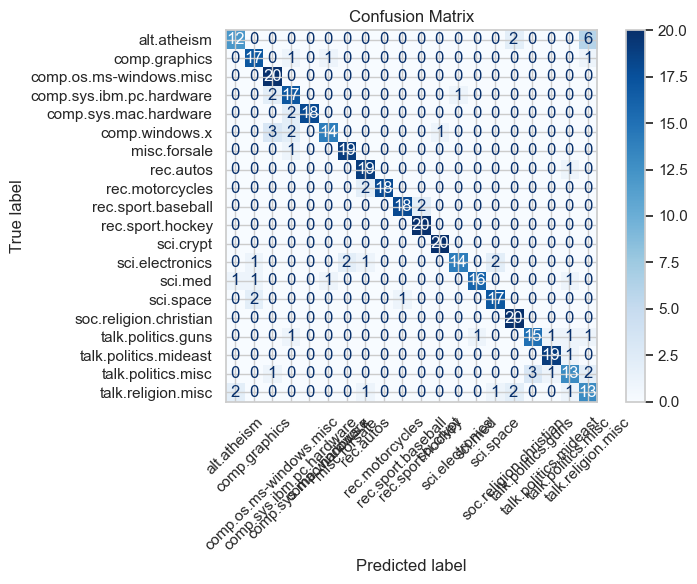

In [7]:
# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
labels = np.unique(y_test)
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [8]:
# Sentiment analysis: try multiple approaches with fallbacks
sentiment_scores = None

# 1) Try vaderSentiment (common and accurate for social text)
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    def get_sentiment_vader(text):
        vs = analyzer.polarity_scores(text)
        comp = vs['compound']
        if comp >= 0.05:
            return 'positive'
        elif comp <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    df['sentiment'] = df['clean_text'].apply(get_sentiment_vader)
    method_used = 'vader'
except Exception as e_v:
    # 2) Try TextBlob if available
    try:
        from textblob import TextBlob
        def get_sentiment_tb(text):
            tb = TextBlob(text)
            pol = tb.sentiment.polarity
            if pol > 0.05:
                return 'positive'
            elif pol < -0.05:
                return 'negative'
            else:
                return 'neutral'
        df['sentiment'] = df['clean_text'].apply(get_sentiment_tb)
        method_used = 'textblob'
    except Exception as e_tb:
        # 3) Fallback: very small lexicon-based approach (guaranteed to run)
        pos_words = set(['good','great','happy','love','excellent','best','nice','awesome','positive','fortunate','correct','superior'])
        neg_words = set(['bad','sad','terrible','awful','worst','hate','negative','poor','angry','problem','issue','pain'])
        def get_sentiment_simple(text):
            tokens = text.split()
            pos_count = sum(1 for t in tokens if t in pos_words)
            neg_count = sum(1 for t in tokens if t in neg_words)
            if pos_count - neg_count > 0:
                return 'positive'
            elif neg_count - pos_count > 0:
                return 'negative'
            else:
                return 'neutral'
        df['sentiment'] = df['clean_text'].apply(get_sentiment_simple)
        method_used = 'simple_lexicon'

print('Sentiment method used:', method_used)
display(df[['clean_text','sentiment']].head(10))

Sentiment method used: simple_lexicon


,clean_text,sentiment
0,path cantaloupe srv cs cmu edu magnesium club ...,neutral
1,newsgroups alt atheism path cantaloupe srv cs ...,neutral
2,path cantaloupe srv cs cmu edu das news harvar...,positive
3,path cantaloupe srv cs cmu edu magnesium club ...,negative
4,xref cantaloupe srv cs cmu edu alt atheism tal...,positive
5,xref cantaloupe srv cs cmu edu talk abortion a...,positive
6,newsgroups alt atheism path cantaloupe srv cs ...,neutral
7,path cantaloupe srv cs cmu edu das news harvar...,neutral
8,xref cantaloupe srv cs cmu edu talk abortion a...,neutral
9,newsgroups alt atheism path cantaloupe srv cs ...,negative


sentiment,negative,neutral,positive
label,,,
alt.atheism,0.12,0.58,0.30
comp.graphics,0.11,0.55,0.34
comp.os.ms-windows.misc,0.22,0.54,0.24
comp.sys.ibm.pc.hardware,0.17,0.55,0.28
comp.sys.mac.hardware,0.16,0.58,0.26
comp.windows.x,0.19,0.61,0.20
misc.forsale,0.02,0.58,0.40
rec.autos,0.13,0.40,0.47
rec.motorcycles,0.11,0.51,0.38


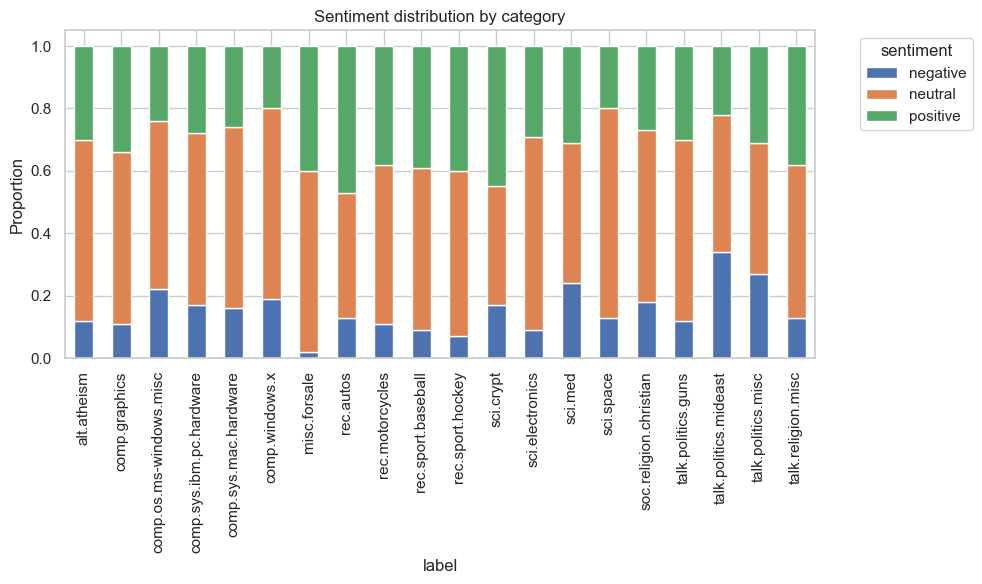

In [9]:
# Sentiment distribution across categories
if 'label' in df.columns:
    senti_dist = df.groupby('label')['sentiment'].value_counts(normalize=True).unstack(fill_value=0)
    display(senti_dist)
    # Bar plot per category (stacked)
    senti_dist.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.ylabel('Proportion')
    plt.title('Sentiment distribution by category')
    plt.legend(title='sentiment', bbox_to_anchor=(1.05,1))
    plt.tight_layout()
    plt.show()

## Discussion & Conclusion
 The TF-IDF + Naive Bayes model gives a strong baseline for text classification, but performance can improve with better preprocessing, hyperparameter tuning, and trying models like Logistic Regression or SVM.
Sentiment analysis works well with VADER/TextBlob but can be enhanced using larger lexicons or transformer models.


 **Sentiment analysis**: The notebook uses Vader if available, otherwise TextBlob, otherwise a simple lexicon fallback. 


  - Perform cross-validation and grid-search for hyperparameters.

  - Add class imbalance handling if some categories are rare.

  - Use larger sentiment lexicons or transformer models for more accurate sentiment analysis.
